# 核心计算

## 感悟

- 怎么简单, 怎么来, 不要太过于繁琐
- 展现关键步骤, 次要的的隐藏
- 尽可能复用代码, 利用现成的

## 实现

### 已知参数


In [1]:
import numpy as np


class Settings:
    """已知参数"""
    def __init__(self):
        self.H = 200
        self.D = 180
        self.e = 40
        self.K = 1.035
        self.conefficient_l_AC2 = 0.38
        self.Q1 = 140
        self.Q2 = 115
        self.Q3 = 190
        self.conefficient_Rho_square = 0.17
        self.n = 650  # 顺时针
        self.Delta = 1 / 100
        self.u_pi = 2  # pi 的比例尺
        self.pi = np.array([
            0, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1.5, -5, -8, -15, -43.5, -140, -140,
            -72.5, -50.5, -32.5, -15, -7.5, -2.5, -2.5, -1, -1, -1, -1, -1, -1
        ])
        self.pi = self.u_pi * self.pi
        self.g = 10

### 求解机构的几何参数

方法如下：

![](pict/1.png)


In [2]:
import math


class Mechanism:
    """曲柄滑块机构的求解计算"""
    def __init__(self, mech_settings):
        self.K = mech_settings.K
        self.H = mech_settings.H
        self.e = mech_settings.e
        self.angle = 180 * (self.K - 1) / (self.K + 1)
        self.theta = math.radians(self.angle)
        self.l = 0
        self.r = 0
        self.__solve()

    def __solve(self):
        """return length and radians"""
        # 三角形圆的半径
        theta = self.theta
        H = self.H
        e = self.e
        R = H / (2 * math.sin(theta))

        CD = R * math.cos(theta)
        OE = math.sqrt(R**2 - (CD - e)**2)
        OF = OE + H / 2

        l_plus_r = math.sqrt(OF**2 + e**2)
        alpha = math.asin(OE / R)
        delta = alpha - theta
        l_minus_r = 2 * R * math.sin(delta / 2)

        self.l = (l_plus_r + l_minus_r) / 2
        self.r = (l_plus_r - l_minus_r) / 2

In [3]:
mech_settings = Settings()
crank_slider = Mechanism(mech_settings)

display("angle = {}".format(crank_slider.angle))
display("l = {}".format(crank_slider.l))
display("r = {}".format(crank_slider.r))

'angle = 3.0958230958230883'

'l = 397.52175616699924'

'r = 99.45807704268577'

### 解析计算

1. 采用状态的想法来组织对象, 根据此时的状态计算位置,速度,加速度,力
2. 在类的内部构造一个主函数, 模块化处理
3. 将速度、加速度等作为子类来处理
4. 简洁处理，不需要传递参数的就不需要
5. 利用复数表达坐标

#### 计算 15 个坐标点


In [4]:
import cmath


class Coord_param:
    """
    ## 计算坐标的关键参数
    """
    def __init__(self):
        self.l_OB_up = 0
        self.l_OB_down = 0
        self.B_up = complex(0, 0)
        self.B_down = complex(0, 0)
        self.theta_list = []
        self.angle_list = []
        self.A_list = []

        self.__main_process()

    def __main_process(self):
        self.__init_data()
        self.__calc_theta_list()
        self.__calc_angle_list()
        self.__calc_A_list()

    def __init_data(self):
        self.l_OB_up = crank_slider.r + crank_slider.l
        self.l_OB_down = abs(crank_slider.r - crank_slider.l)
        self.__calc_B_up()
        self.__calc_B_down()

    def __calc_B_up(self):
        B_up_temp_x = mech_settings.e
        B_up_temp_y = self.__calc_By(self.l_OB_up)
        self.B_up = B_up_temp_x + B_up_temp_y * 1j

    def __calc_B_down(self):
        B_down_temp_x = mech_settings.e
        B_down_temp_y = self.__calc_By(self.l_OB_down)
        self.B_down = B_down_temp_x + B_down_temp_y * 1j

    def __calc_By(self, l):
        return (l**2 - mech_settings.e**2)**0.5

    def __calc_theta_list(self):
        theta0 = cmath.polar(self.B_up)[1]
        temp_theta_list = []
        # 角度相差 30 度
        delta_theta = math.pi / 6
        for i in range(0, 12):
            temp_theta = theta0 - i * delta_theta
            temp_theta_list.append(temp_theta)
        # 加入 6' 点
        theta6 = cmath.polar(self.B_down)[1] - math.pi
        temp_theta_list.append(theta6)
        # 加入 2' 和 9'
        temp_l_OB = math.hypot(crank_slider.r, crank_slider.l)
        temp_By = self.__calc_By(temp_l_OB)
        theta_OB = cmath.polar(mech_settings.e + temp_By * 1j)[1]
        theta_OBA = cmath.polar(crank_slider.r + crank_slider.l * 1j)[1]
        theta_2_prime = theta_OB - theta_OBA
        # 首先确定角度, 然后减去 2 * pi ,使得排在第 9' 处
        theta_9_prime = theta_OB + theta_OBA - 2 * math.pi
        temp_theta_list.extend([theta_2_prime, theta_9_prime])
        temp_theta_list.sort(reverse=True)

        self.theta_list = temp_theta_list.copy()

    def __calc_angle_list(self):
        temp_angle_list = []
        for i in range(0, len(self.theta_list)):
            temp_angle_list.append(math.degrees(self.theta_list[i]))
        self.angle_list = temp_angle_list.copy()

    def __calc_A_list(self):
        temp_A_list = []
        for i in range(0, len(self.theta_list)):
            temp_A = cmath.rect(crank_slider.r, self.theta_list[i])
            temp_A_list.append(temp_A)
        self.A_list = temp_A_list.copy()


coord_param = Coord_param()

# test
#display(cood_param.angle_list)

#### 状态

##### position


In [5]:
from func import graphic


class Position:
    def __init__(self, id_name, theta):
        self.id_name = id_name
        self.theta = theta
        self.theta_AB = 0
        self.A = complex(0, 0)
        self.B = complex(0, 0)
        self.AB = complex(0, 0)
        self.l_OA = 0
        self.l_OB = 0

        self.__main_process()

    def __main_process(self):
        self.l_OA = crank_slider.r
        self.l_AB = crank_slider.l
        self.__calc_A()
        self.__calc_B()
        self.AB = self.B - self.A
        self.__calc_theta_AB()

    def __calc_A(self):
        self.A = cmath.rect(self.l_OA, self.theta)

    def __calc_B(self):
        temp_B_x = mech_settings.e
        temp_B_y = self.A.imag + (self.l_AB**2 -
                                  (self.A.real - temp_B_x)**2)**0.5
        self.B = temp_B_x + temp_B_y * 1j

    def __calc_theta_AB(self):
        self.theta_AB = cmath.polar(self.AB)[1]
        
    def draw(self):
        graphic.draw_position_figure(coord_param, self.A, self.B,
                                     crank_slider.r, self.id_name)


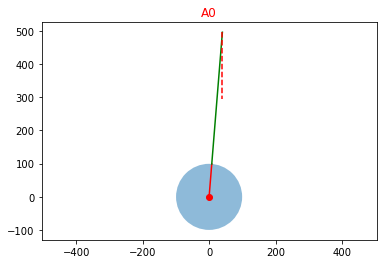

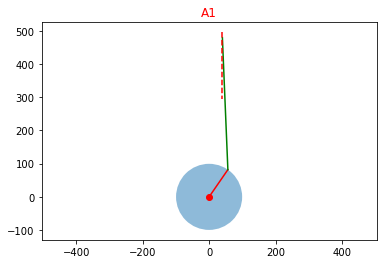

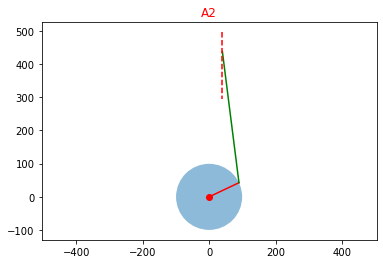

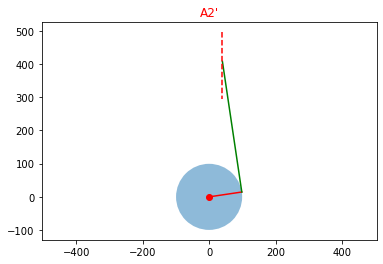

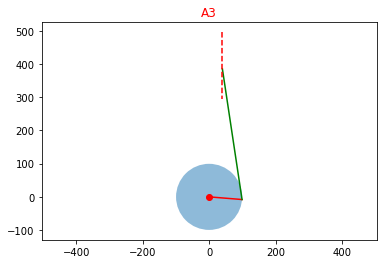

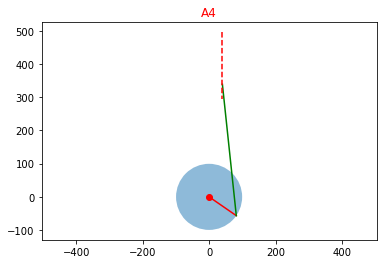

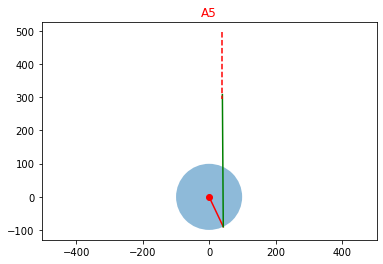

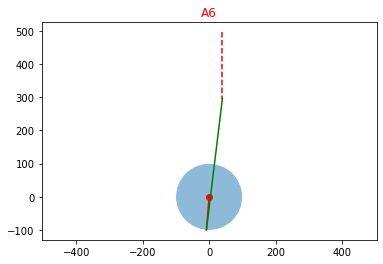

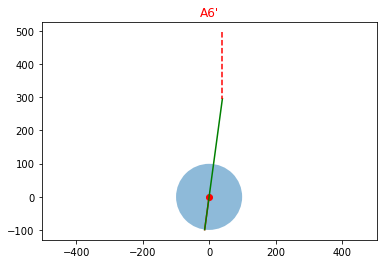

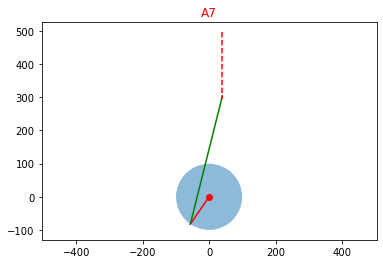

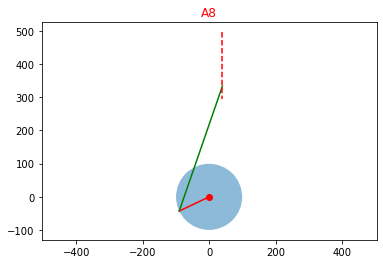

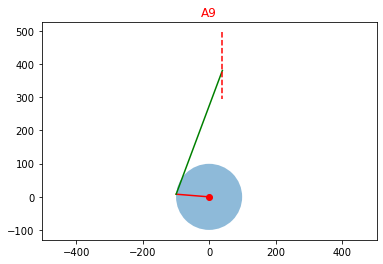

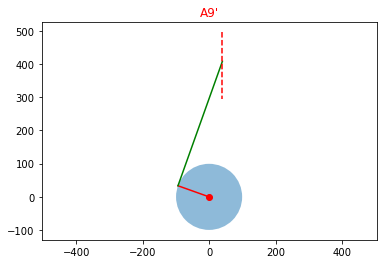

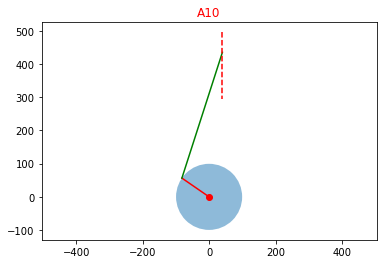

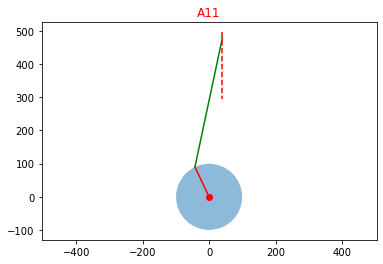

In [6]:
from func import test_for_my

pos_list = []

for theta, id_name in zip(coord_param.theta_list, test_for_my.name_list_2):
    pos = Position(id_name, theta)
    pos.draw()
    pos_list.append(pos)

##### velocity


In [7]:
from func import tool


class Velocity:
    """存储的形式尽量简单, 包含的信息尽可能丰富,
       角速度是有正负的
    """
    def __init__(self, position):
        self.position = position
        self.omega_OA = 0
        self.omega_AB = 0
        self.v_OA = complex(0, 0)
        self.v_AB = complex(0, 0)
        self.v_OB = complex(0, 0)
        self.v_C2 = complex(0, 0)

        self.__main_process()

    def __main_process(self):
        self.__calc_omega_OA()
        v_OA_len = abs(self.omega_OA * self.position.l_OA)
        # 速度方向刚好是 OA 顺时针旋转 90度
        self.v_OA = cmath.rect(v_OA_len, self.position.theta) * (-1j)
        self.__calc_v_OB()
        self.v_AB = self.v_OB - self.v_OA
        self.__calc_omega_AB()
        self.__calc_v_C2()

    def __calc_omega_OA(self):
        self.omega_OA = -2 * math.pi * mech_settings.n / 60  # 有方向

    def __calc_v_OB(self):
        temp_PA = self.v_OA
        temp_theta_pos_AB = self.position.theta_AB  # 取位置的角度
        temp_theta_AB = temp_theta_pos_AB + math.pi / 2  # 速度与位置垂直
        temp_theta_PB = math.pi / 2  # 速度沿着竖直方向
        (temp_OB_x, temp_OB_y) = tool.solve_triangle(temp_PA, temp_theta_AB,
                                                     temp_theta_PB)
        self.v_OB = complex(temp_OB_x, temp_OB_y)

    def __calc_omega_AB(self):
        # 分析 v = w X l
        # 带入二维
        # vx = - w * y
        # vy = w * x
        # 理解其中的含义， w 的正负代表逆时针旋转和顺时针旋转
        # 用复数的观点是, 二者垂直, 则相除后, 在虚轴上, 虚部的正负恰好为 w 的正负
        # 可以使用复数的指数形式来证明
        self.omega_AB = (self.v_AB / self.position.AB).imag
    def __calc_v_C2(self):
        temp_v_AC2 = self.v_AB * mech_settings.conefficient_l_AC2
        self.v_C2 = self.v_OA + temp_v_AC2

    def draw(self):
        graphic.draw_velocity_figure(self.v_OA, self.v_OB, self.v_C2,
                                     self.position.id_name)


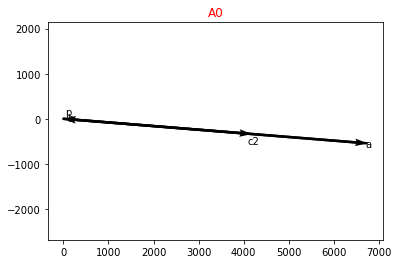

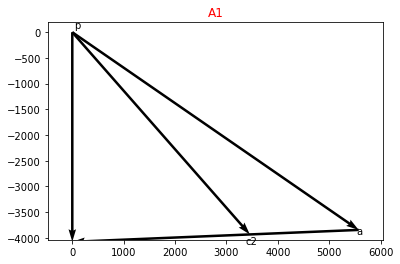

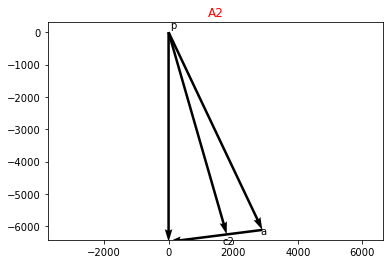

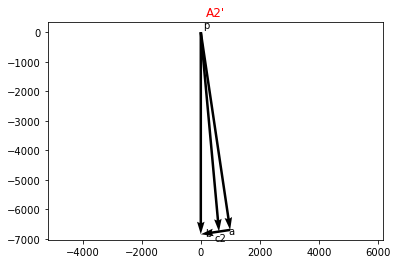

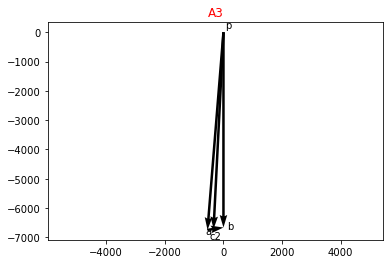

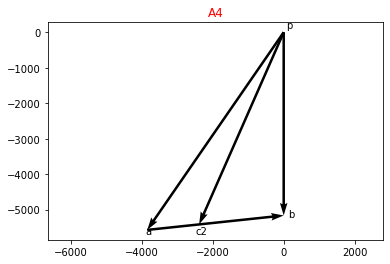

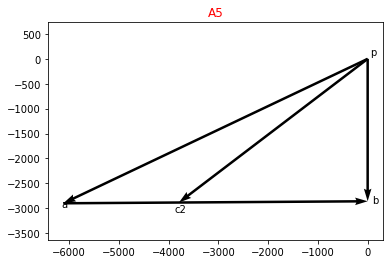

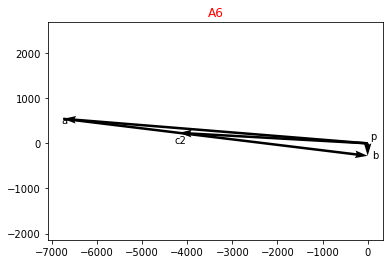

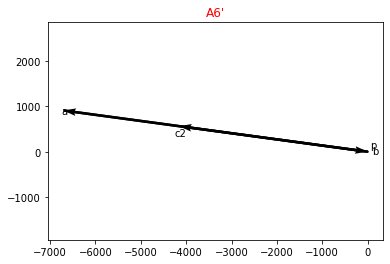

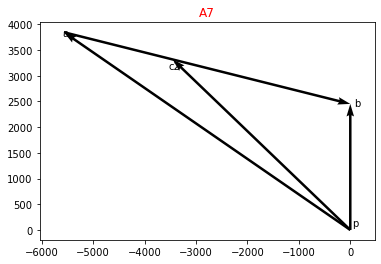

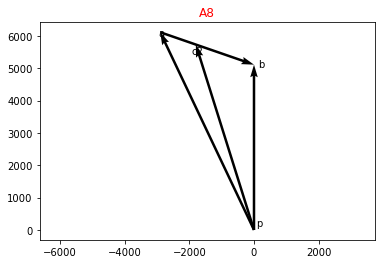

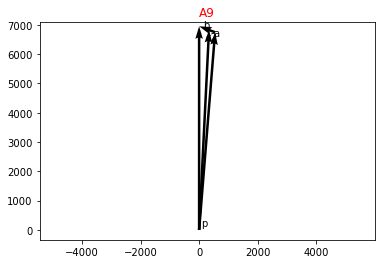

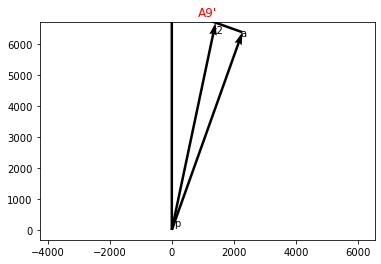

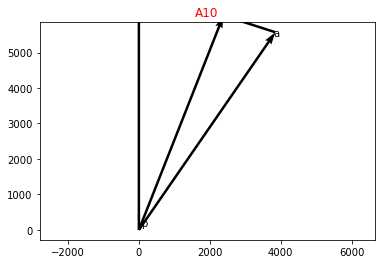

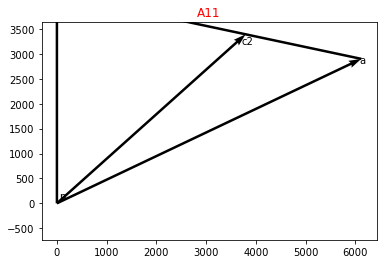

In [8]:
vel_list = []

for pos in pos_list:
    vel = Velocity(pos)
    vel.draw()
    vel_list.append(vel)
    # test
    #display(vel.v_OB)



##### acceleration

In [9]:
class Acceleration:
    def __init__(self, velocity):
        self.velocity = velocity
        self.a_OA = complex(0, 0)
        self.a_AB = complex(0, 0)
        self.a_OB = complex(0, 0)
        self.a_C2 = complex(0, 0)
        self.a_AB_t = complex(0, 0)
        self.a_AB_n = complex(0, 0)
        self.a_OD = complex(0, 0)  # 也就是切向与法向的交点

        self.__main_process()

    def __main_process(self):
        self.__calc_a_OA()
        self.__calc_a_AB_n()
        self.a_OD = self.a_OA + self.a_AB_n
        self.__calc_a_OB()
        self.a_AB_t = self.a_OB - self.a_OD
        self.a_AB = self.a_AB_t + self.a_AB_n
        self.__calc_a_C2()

    def __calc_a_OA(self):
        temp_omega_OA = self.velocity.omega_OA
        temp_l_OA = self.velocity.position.l_OA
        a_OA_len = temp_omega_OA**2 * temp_l_OA
        temp_theta_OA = self.velocity.position.theta
        # 与位置方向相反
        self.a_OA = cmath.rect(a_OA_len, temp_theta_OA) * (-1)

    def __calc_a_AB_n(self):
        temp_omega_AB = self.velocity.omega_AB
        temp_l_AB = self.velocity.position.l_AB
        a_AB_t_len = temp_omega_AB**2 * temp_l_AB
        temp_theta_AB = self.velocity.position.theta_AB
        # 与位置方向相反
        self.a_AB_n = cmath.rect(a_AB_t_len, temp_theta_AB) * (-1)

    def __calc_a_OB(self):
        temp_PA = self.a_OD
        temp_theta_AB = self.velocity.position.theta_AB + math.pi / 2
        temp_theta_PB = math.pi / 2
        (temp_OB_x, temp_OB_y) = tool.solve_triangle(temp_PA, temp_theta_AB,
                                                     temp_theta_PB)
        self.a_OB = complex(temp_OB_x, temp_OB_y)

    def __calc_a_C2(self):
        temp_a_AC2 = self.a_AB * mech_settings.conefficient_l_AC2
        self.a_C2 = self.a_OA + temp_a_AC2

    def draw(self):
        graphic.draw_acceleration_figure(self.a_OA, self.a_OB, self.a_OD,
                                         self.a_C2,
                                         self.velocity.position.id_name)


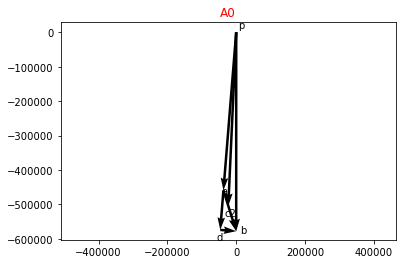

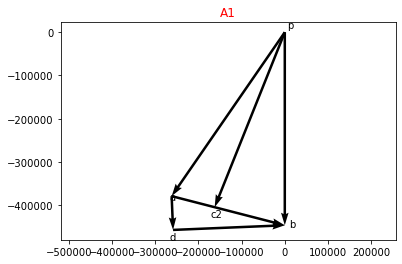

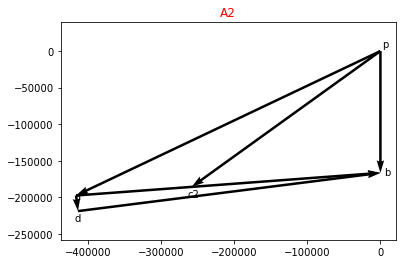

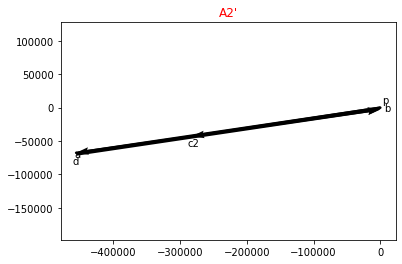

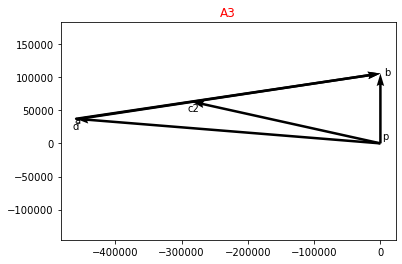

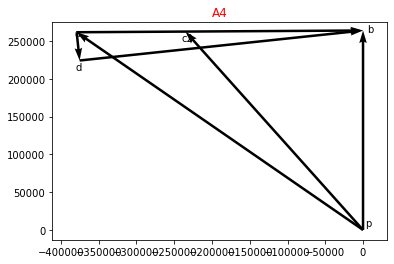

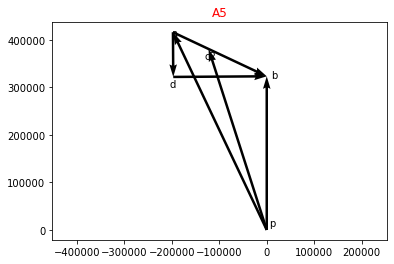

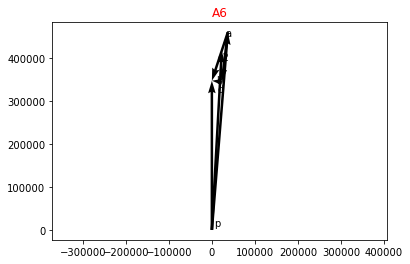

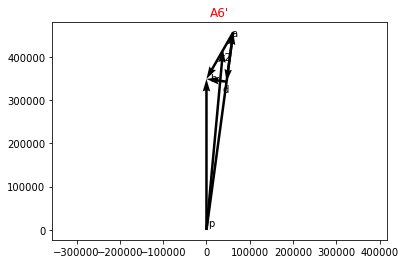

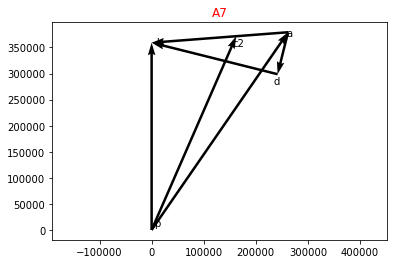

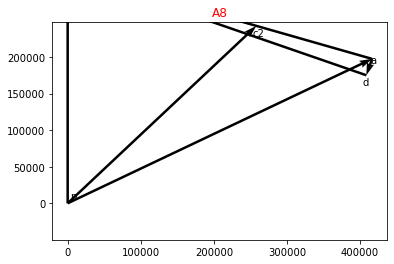

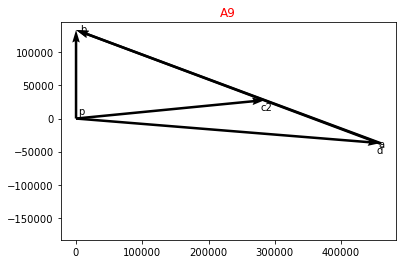

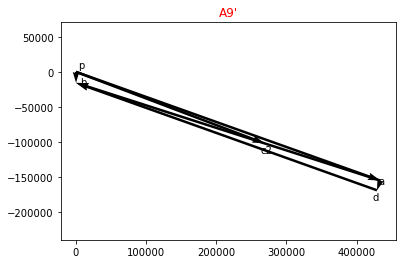

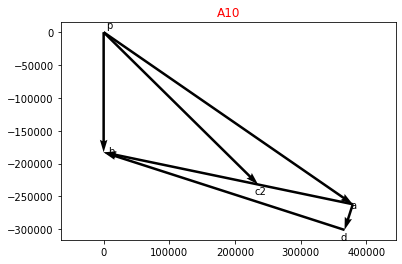

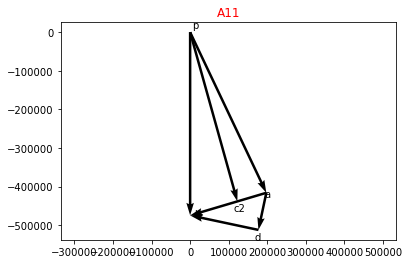

In [10]:
acc_list = []

for vel in vel_list:
    acc = Acceleration(vel)
    acc.draw()
    acc_list.append(acc)

##### sketch

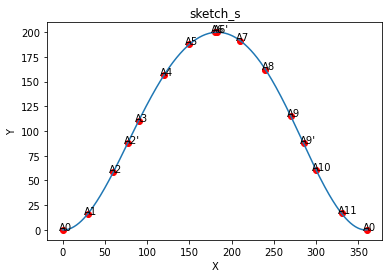

In [11]:
angle_list = [math.degrees(pos.theta) for pos in pos_list]
journey_list = [pos.B.imag for pos in pos_list]
graphic.draw_sketch_s(angle_list, journey_list, 'sketch_s')

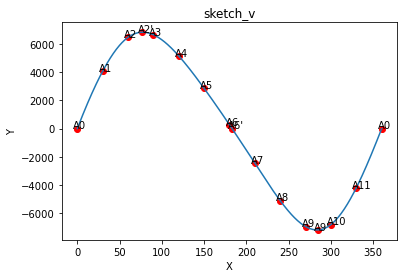

In [12]:
B_vel_list = [vel.v_OB.imag for vel in vel_list]
graphic.draw_sketch_v(angle_list, B_vel_list, 'sketch_v')

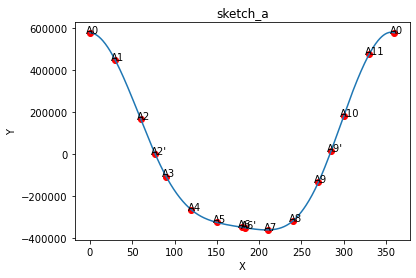

In [13]:
B_acc_list = [acc.a_OB.imag for acc in acc_list]
graphic.draw_sketch_a(angle_list, B_acc_list, 'sketch_a')